# Problem

**State Space**

The state space consists of two discrete states:
$$
\mathcal{X} = \{0, 1\}.
$$

These can be interpreted as two different situations or system configurations, for instance, a “low-performance” state (0) and a “high-performance” state (1).

 **Action Space**

The action space consists of two discrete actions:
$$
\mathcal{A} = \{0, 1\}.
$$

These actions can be thought of as two control options available to the agent — for example:

* **Action 0**: Conservative or “stay” action (keeps the system near state 0)
* **Action 1**: Aggressive or “move” action (pushes the system toward state 1)

**Reward Function**

The reward is explicitly given by:
$$
r(x,a) = x + a.
$$

This means:
* Rewards increase with higher actions.
* Being in the “high” state (1) also provides additional reward.

**Transition Function**

Deterministic transition dynamics:

* If the agent takes **action 0**, it always transitions to state 0.
* If the agent takes **action 1**, it always transitions to state 1.

In tabular form:

| Current (x,a) | P(x′=0) | P(x′=1) |
| ------------- | ------- | ------- |
| (0,0)         | 1.0     | 0.0     |
| (0,1)         | 0.0     | 1.0     |
| (1,0)         | 1.0     | 0.0     |
| (1,1)         | 0.0     | 1.0     |

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
# Add project root to the Python path
sys.path.append(str(PROJECT_ROOT))

from fogas import FOGASSolver, FOGASOracleSolver, FOGASHyperOptimizer, FOGASEvaluator, PolicySolver
from fogas.algorithm import FOGASSolverVectorized, FOGASOracleSolverVectorized

# Tabular Features

## Definition

**Feature Map** 

We use a one-hot feature representation over state–action pairs.  
Each feature corresponds to a unique \((x,a)\) combination.

The feature map is defined as:
$$
\phi(x,a) \in \mathbb{R}^4
$$

with the ordering:
$$
(0,0) \rightarrow e_0,\quad
(0,1) \rightarrow e_1,\quad
(1,0) \rightarrow e_2,\quad
(1,1) \rightarrow e_3
$$

**Reward Weights**

The reward function is linear in the features:
$$
r(x,a) = \phi(x,a)^\top \omega,
$$

with weight vector:
$$
\omega =
\begin{bmatrix}
0 \\
1 \\
1 \\
2
\end{bmatrix}.
$$

**Transition Weights**

The transition model is also linear in the features:
$$
p(x' \mid x,a) = \phi(x,a)^\top \psi(x').
$$

The transition weight vectors are:
$$
\psi(0) =
\begin{bmatrix}
1 \\
0 \\
1 \\
0
\end{bmatrix},
\quad
\psi(1) =
\begin{bmatrix}
0 \\
1 \\
0 \\
1
\end{bmatrix}.
$$


## Testing

In [2]:
states_2d = np.array([0, 1])
actions_2d = np.array([0, 1])
gamma_2d = 0.99
x_0 = 0 # fixed initial state

def phi(state, action):
    vec = np.zeros(4)
    vec[state * 2 + action] = 1.0
    return vec

omega = np.array([0, 1.0, 1.0, 2.0])

psi = {
    0: np.array([1.0, 0, 1.0, 0]),
    1: np.array([0, 1.0, 0, 1.0])
}


mdp = PolicySolver(states=states_2d, actions=actions_2d, phi=phi, omega=omega, gamma=gamma_2d, x0=x_0, psi=psi)

### Oracle

In [3]:
solver = FOGASOracleSolver(mdp=mdp, cov_matrix="identity", print_params=True, T=400)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.0000
Num states N:             2
Num actions A:            2
Feature dim d:            4
Discount γ:               0.99
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      4627564.263195183
T (iterations):                400   (overridden → 400)

FOGAS Hyperparameters
---------------------
alpha:                        0.000294
rho:                            6.969724
eta:                            0.000024
D_theta:                    20.000000
beta (ridge):             0.000625
D_pi (derived):           2.354820





=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -1.0040
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=7.9629e-01, rho=5.0000e+00, eta=2.4056e-05 | metric = -1.9175

Optimizing rho
[After rho*] alpha=7.9629e-01, rho=5.0000e+00, eta=2.4056e-05 | metric = -1.9175

Optimizing eta
[After eta*] alpha=7.9629e-01, rho=5.0000e+00, eta=1.3680e-01 | metric = -1.9896


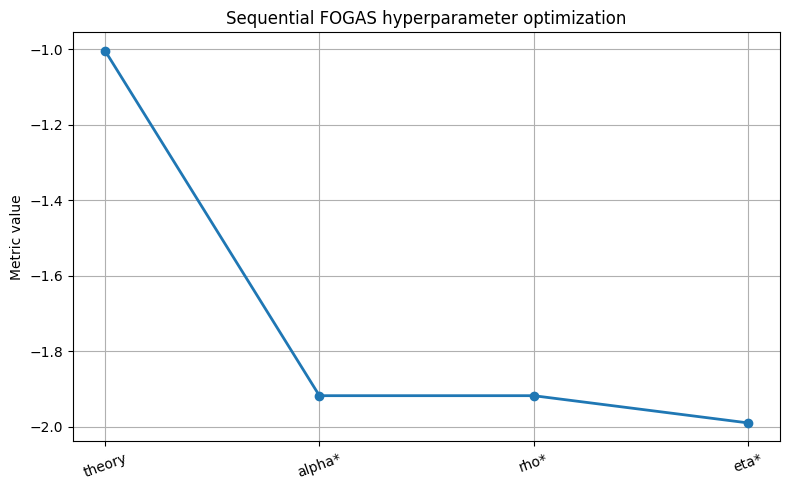

In [4]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]


In [5]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS:   0%|          | 0/400 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 400/400 [00:00<00:00, 9692.77it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  199.000000 | Δ =  0.000000e+00
State 1: V*(x) =  200.000000 | V^π(x) =  200.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  197.010000 | Δ =  0.000000e+00
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  199.000000 | Δ =  0.000000e+00
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  198.010000 | Δ =  0.000000e+00
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  200.000000 | Δ =  0.000000e+00

Norm diagnostics:
||V^π - V*||_2 = 0.000000e+00
||Q^π - Q*||_2 = 0.000000e+00




### Oracle vectorized

In [6]:
solver = FOGASOracleSolverVectorized(mdp=mdp, cov_matrix="identity", print_params=True, T=400)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.0000
Num states N:             2
Num actions A:            2
Feature dim d:            4
Discount γ:               0.99
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      4627564.263195183
T (iterations):                400   (overridden → 400)

FOGAS Hyperparameters
---------------------
alpha:                        0.000294
rho:                            6.969724
eta:                            0.000024
D_theta:                    20.000000
beta (ridge):             0.000625
D_pi (derived):           2.354820





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -1.0042
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=1.7731e+00, rho=1.0000e-02, eta=2.4056e-05 | metric = -1.9900

Optimizing rho
[After rho*] alpha=1.7731e+00, rho=1.0000e-02, eta=2.4056e-05 | metric = -1.9900

Optimizing eta
[After eta*] alpha=1.7731e+00, rho=1.0000e-02, eta=3.9782e-02 | metric = -1.9900


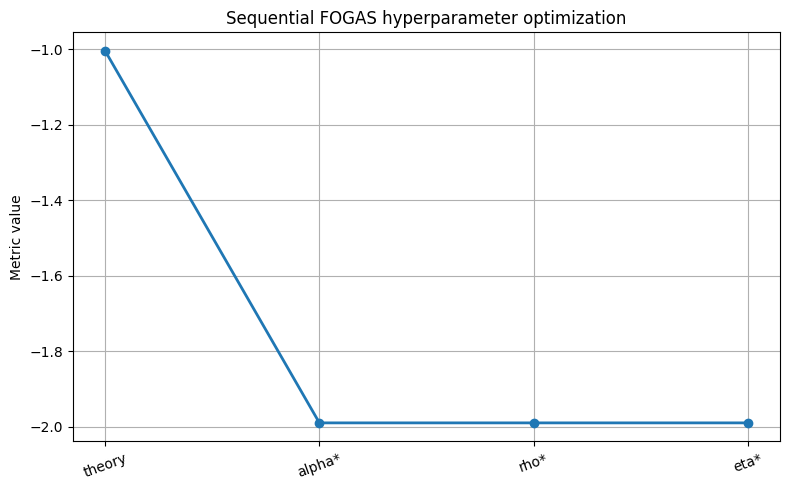

In [7]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]


In [8]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS Oracle:   0%|          | 0/400 [00:00<?, ?it/s]

FOGAS Oracle: 100%|██████████| 400/400 [00:00<00:00, 6895.83it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  199.000000 | Δ =  0.000000e+00
State 1: V*(x) =  200.000000 | V^π(x) =  200.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  197.010000 | Δ =  0.000000e+00
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  199.000000 | Δ =  0.000000e+00
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  198.010000 | Δ =  0.000000e+00
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  200.000000 | Δ =  0.000000e+00

Norm diagnostics:
||V^π - V*||_2 = 0.000000e+00
||Q^π - Q*||_2 = 0.000000e+00




### Empirical

In [9]:
solver_e = FOGASSolver(mdp=mdp, print_params=True, csv_path="/home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/dumb_problem.csv")
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           100
Feature norm bound R:     1.0000
Num states N:             2
Num actions A:            2
Feature dim d:            4
Discount γ:               0.99
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      46.27564263195184
T (iterations):                47

FOGAS Hyperparameters
---------------------
alpha:                        0.000859
rho:                            1945.036816
eta:                            0.000070
D_theta:                    20.000000
beta (ridge):             0.005319
D_pi (derived):           0.807192




Trying same optimal hyperparameters found for the oracle.

In [10]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/47 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 47/47 [00:00<00:00, 171.25it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  198.971359 | Δ = -2.864146e-02
State 1: V*(x) =  200.000000 | V^π(x) =  199.971071 | Δ = -2.892907e-02

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  196.981645 | Δ = -2.835505e-02
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  198.971360 | Δ = -2.863978e-02
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  197.981645 | Δ = -2.835505e-02
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  199.971360 | Δ = -2.863978e-02

Norm diagnostics:
||V^π - V*||_2 = 4.070902e-02
||Q^π - Q*||_2 = 5.699553e-02



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 1.990000
J(π_FOGAS) = 1.989714
Gap (J* − J) = 2.864146e-04





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -1.0480
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=2.3155e+00, rho=1.9450e+03, eta=7.0179e-05 | metric = -1.9900

Optimizing rho
[After rho*] alpha=2.3155e+00, rho=1.8742e+00, eta=7.0179e-05 | metric = -1.9900

Optimizing eta
[After eta*] alpha=2.3155e+00, rho=1.8742e+00, eta=7.0179e-05 | metric = -1.9900


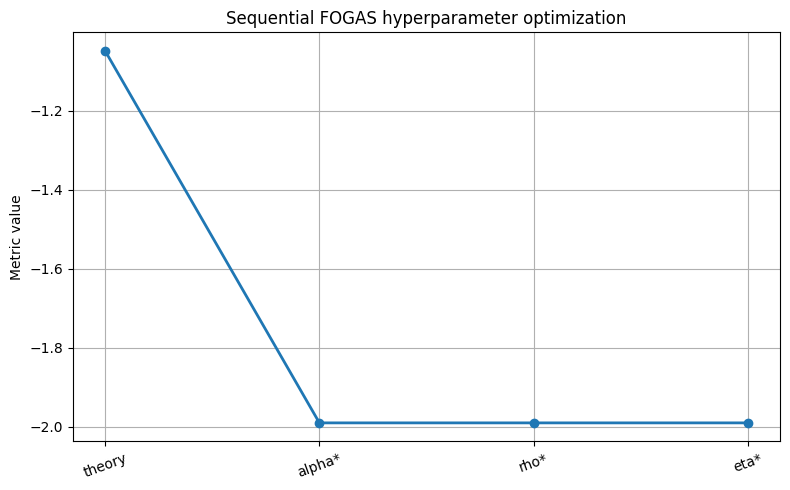

In [11]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [12]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/47 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 47/47 [00:00<00:00, 168.06it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  199.000000 | Δ = -1.705303e-13
State 1: V*(x) =  200.000000 | V^π(x) =  200.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  197.010000 | Δ = -1.705303e-13
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  199.000000 | Δ =  0.000000e+00
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  198.010000 | Δ = -1.705303e-13
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  200.000000 | Δ =  0.000000e+00

Norm diagnostics:
||V^π - V*||_2 = 1.705303e-13
||Q^π - Q*||_2 = 2.411662e-13



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 1.990000
J(π_FOGAS) = 1.990000
Gap (J* − J) = 1.554312e-15




### Empirical vectorized

In [13]:
solver_e = FOGASSolverVectorized(mdp=mdp, print_params=True, csv_path="/home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/dumb_problem.csv")
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           100
Feature norm bound R:     1.0000
Num states N:             2
Num actions A:            2
Feature dim d:            4
Discount γ:               0.99
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      46.27564263195184
T (iterations):                47

FOGAS Hyperparameters
---------------------
alpha:                        0.000859
rho:                            1945.036816
eta:                            0.000070
D_theta:                    20.000000
beta (ridge):             0.005319
D_pi (derived):           0.807192




Trying same optimal hyperparameters found for the oracle.

In [14]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS: 100%|██████████| 47/47 [00:00<00:00, 11041.35it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  199.000000 | Δ = -1.159037e-08
State 1: V*(x) =  200.000000 | V^π(x) =  200.000000 | Δ = -1.170744e-08

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  197.010000 | Δ = -1.147447e-08
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  199.000000 | Δ = -1.159037e-08
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  198.010000 | Δ = -1.147447e-08
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  200.000000 | Δ = -1.159037e-08

Norm diagnostics:
||V^π - V*||_2 = 1.647425e-08
||Q^π - Q*||_2 = 2.306513e-08



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 1.990000
J(π_FOGAS) = 1.990000
Gap (J* − J) = 1.159037e-10





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -1.0469
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=2.8914e+00, rho=1.9450e+03, eta=7.0179e-05 | metric = -1.9900

Optimizing rho
[After rho*] alpha=2.8914e+00, rho=4.2141e+00, eta=7.0179e-05 | metric = -1.9900

Optimizing eta
[After eta*] alpha=2.8914e+00, rho=4.2141e+00, eta=6.6243e-04 | metric = -1.9900


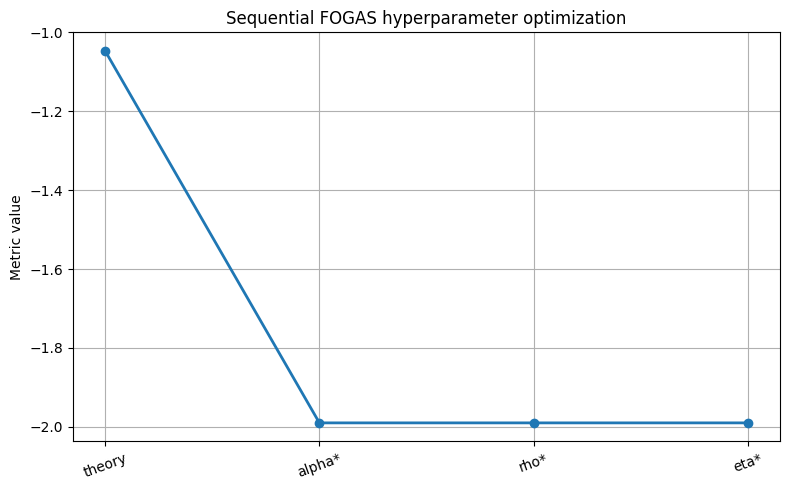

In [15]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [16]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS: 100%|██████████| 47/47 [00:00<00:00, 6452.56it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  199.000000 | Δ =  0.000000e+00
State 1: V*(x) =  200.000000 | V^π(x) =  200.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  197.010000 | Δ =  0.000000e+00
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  199.000000 | Δ =  0.000000e+00
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  198.010000 | Δ =  0.000000e+00
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  200.000000 | Δ =  0.000000e+00

Norm diagnostics:
||V^π - V*||_2 = 0.000000e+00
||Q^π - Q*||_2 = 0.000000e+00



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 1.990000
J(π_FOGAS) = 1.990000
Gap (J* − J) = 0.000000e+00




# Funky Features

## Definition

**Feature Map**

The MDP follows the **Linear MDP assumption**, where both the reward and transition dynamics are linear in a known feature map $ \phi(x,a) $.

The feature representation is defined as:
$$
\phi(x,a) = 2 *
\begin{bmatrix}
1 \\
x \\
a
\end{bmatrix}
\in \mathbb{R}^3.
$$

**Reward Function**

The reward function is a linear combination of the feature vector:
$$
r(x,a) = \phi(x,a)^\top \omega,
$$
with the weight vector
$$
\omega = \frac{1}{2}
\begin{bmatrix}
0 \\
1 \\
1
\end{bmatrix}.
$$

**Transition Function**

The transition model is also linear in the features.
We define a collection of transition weight vectors $ \psi(x') $ such that
$$
p(x'|x,a) = \phi(x,a)^\top \psi(x').
$$

Specifically, the weights are:
$$
\psi(0) = \frac{1}{2}
\begin{bmatrix}
1 \\
0 \\
-1
\end{bmatrix}, \quad
\psi(1) = \frac{1}{2}
\begin{bmatrix}
0 \\
0 \\
1
\end{bmatrix}.
$$

## Testing

In [2]:
states_2d = np.array([0, 1])
actions_2d = np.array([0, 1])
gamma_2d = 0.99
x_0 = 0 # fixed initial state

def phi(state, action):
    return 2 * np.array([1.0, float(state), float(action)])

omega = np.array([0, 0.5, 0.5]) # reward depends on x and a

psi = {
    0: 0.5 * np.array([1.0, 0.0, -1.0]),  # transition weights for next state 0
    1: 0.5 * np.array([0.0, 0.0, 1.0])   # transition weights for next state 1
}

mdp = PolicySolver(states=states_2d, actions=actions_2d, phi=phi, omega=omega, gamma=gamma_2d, x0=x_0, psi=psi)

### Oracle

In [3]:
solver = FOGASOracleSolver(mdp=mdp, cov_matrix="identity", print_params=True, T=600)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     3.4641
Num states N:             2
Num actions A:            2
Feature dim d:            3
Discount γ:               0.99
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      55530771.1583422
T (iterations):                600   (overridden → 600)

FOGAS Hyperparameters
---------------------
alpha:                        0.000080
rho:                            5.335644
eta:                            0.000008
D_theta:                    17.320508
beta (ridge):             0.006667
D_pi (derived):           0.832555




Only when changing orders: first eta!! It is the most important one here.


=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -0.7041
Order: ('eta', 'rho', 'alpha')

Optimizing eta
[After eta*] alpha=8.0113e-05, rho=1.0000e-02, eta=8.8077e-01 | metric = -1.0403

Optimizing rho
[After rho*] alpha=8.0113e-05, rho=1.0000e-03, eta=8.8077e-01 | metric = -1.0410

Optimizing alpha
[After alpha*] alpha=3.4658e-02, rho=1.0000e-03, eta=8.8077e-01 | metric = -1.9900


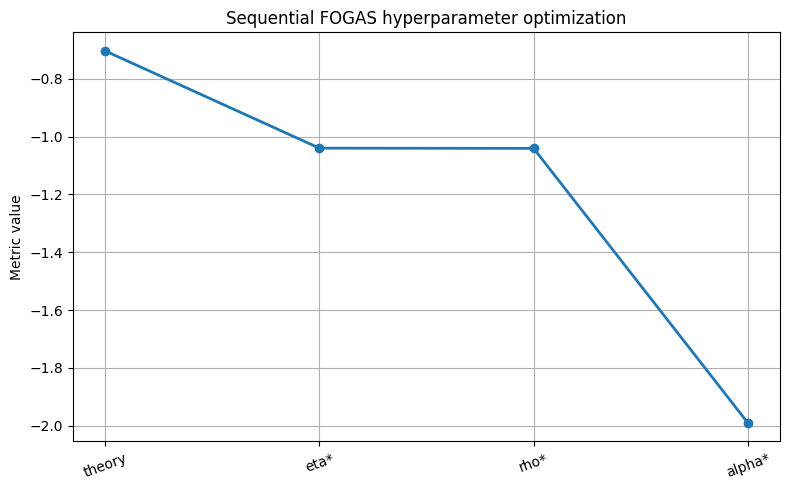

In [6]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("eta", "rho", "alpha")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [8]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS:   0%|          | 0/600 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 600/600 [00:00<00:00, 6593.49it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  199.000000 | Δ =  3.410605e-13
State 1: V*(x) =  200.000000 | V^π(x) =  200.000000 | Δ =  3.410605e-13

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  197.010000 | Δ =  3.410605e-13
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  199.000000 | Δ =  3.410605e-13
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  198.010000 | Δ =  3.410605e-13
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  200.000000 | Δ =  3.410605e-13

Norm diagnostics:
||V^π - V*||_2 = 4.823324e-13
||Q^π - Q*||_2 = 6.821210e-13




### Empirical

In [9]:
solver_e = FOGASSolver(mdp=mdp, print_params=True, csv_path="/home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/dumb_problem.csv")
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"))


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           100
Feature norm bound R:     3.4641
Num states N:             2
Num actions A:            2
Feature dim d:            3
Discount γ:               0.99
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      555.3077115834219
T (iterations):                556

FOGAS Hyperparameters
---------------------
alpha:                        0.000083
rho:                            1680.895969
eta:                            0.000008
D_theta:                    17.320508
beta (ridge):             0.007194
D_pi (derived):           0.801446




Trying same optimal hyperparameters found for the oracle.

In [10]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/556 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 556/556 [00:03<00:00, 154.75it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  195.687547 | Δ = -3.312453e+00
State 1: V*(x) =  200.000000 | V^π(x) =  196.687547 | Δ = -3.312453e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  193.730672 | Δ = -3.279328e+00
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  195.720672 | Δ = -3.279328e+00
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  194.730672 | Δ = -3.279328e+00
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  196.720672 | Δ = -3.279328e+00

Norm diagnostics:
||V^π - V*||_2 = 4.684516e+00
||Q^π - Q*||_2 = 6.558657e+00



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 1.990000
J(π_FOGAS) = 1.956875
Gap (J* − J) = 3.312453e-02





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = -0.7642
Order: ('eta', 'rho', 'alpha')

Optimizing eta
[After eta*] alpha=8.3222e-05, rho=1.6809e+03, eta=1.0000e+00 | metric = -0.8018

Optimizing rho
[After rho*] alpha=8.3222e-05, rho=1.0000e-03, eta=1.0000e+00 | metric = -1.0414

Optimizing alpha
[After alpha*] alpha=1.0217e+00, rho=1.0000e-03, eta=1.0000e+00 | metric = -1.9900


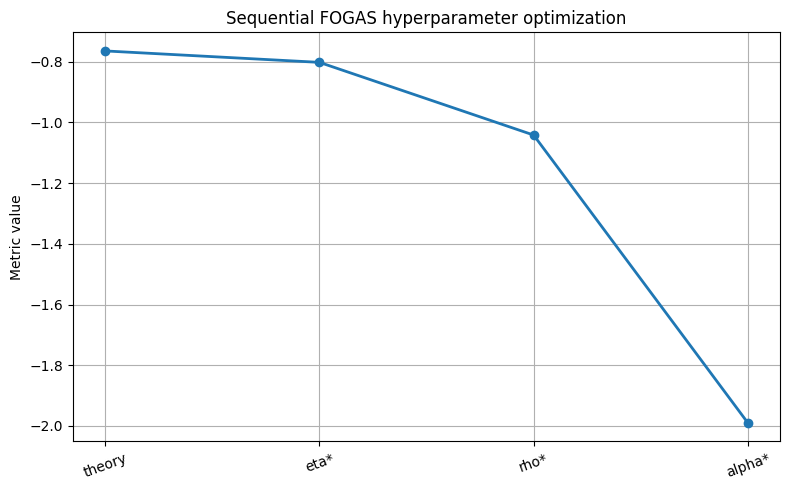

In [11]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("eta", "rho", "alpha")
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [12]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/556 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 556/556 [00:03<00:00, 150.61it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  199.000000 | V^π(x) =  199.000000 | Δ =  1.193712e-12
State 1: V*(x) =  200.000000 | V^π(x) =  200.000000 | Δ =  1.193712e-12

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  197.010000 | Q^π(x,a) =  197.010000 | Δ =  1.193712e-12
(x=0, a=1): Q*(x,a) =  199.000000 | Q^π(x,a) =  199.000000 | Δ =  1.193712e-12
(x=1, a=0): Q*(x,a) =  198.010000 | Q^π(x,a) =  198.010000 | Δ =  1.193712e-12
(x=1, a=1): Q*(x,a) =  200.000000 | Q^π(x,a) =  200.000000 | Δ =  1.193712e-12

Norm diagnostics:
||V^π - V*||_2 = 1.688163e-12
||Q^π - Q*||_2 = 2.387424e-12



========== FINAL REWARD COMPARISON ==========

J*(π*)   = 1.990000
J(π_FOGAS) = 1.990000
Gap (J* − J) = -1.199041e-14


